# Problem Statement

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# EDA
### Data Cleaning, Feature engineering and visualization.

 # Data Cleaning

In [7]:
# loading training dataset
df = pd.read_csv('dataset/full_COA_v2.csv.' , parse_dates=True , index_col='Time')[['COA','temp','dewPoint','humidity','windSpeed']]

In [8]:
# take a look at the head of the training data set
df.head()

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2012-01-01 01:00:00,5986.0,13.98,0.01,0.38,3.09
2012-01-01 02:00:00,5547.0,11.98,0.99,0.47,2.06
2012-01-01 03:00:00,5233.0,11.98,0.99,0.47,2.06
2012-01-01 04:00:00,5150.0,11.98,0.01,0.44,2.06
2012-01-01 05:00:00,5235.0,11.98,0.01,0.44,3.60


In [9]:
df_l = df.resample('D').max()

In [10]:
df_l['year'] = df_l.index.map(lambda x: x.year)
df_l['quarter'] = df_l.index.map(lambda x: x.quarter)
df_l['month'] = df_l.index.map(lambda x: x.month)
df_l['weekday_name']=df_l.index.strftime("%A")
df_l['hour_24']=df_l.index.strftime("%H")
df_l['weekday_no']=df_l.index.map(lambda x:x.weekday())
# Setting up the weekend boolean for the Thursday & Friday weekend (Before 29-6-2013)
df_l[:'2013-06-29']['weekend_bool']=df_l.weekday_no.apply(lambda x: int(1) if x==3 or x==4 else int(0))

# Setting up the weekend boolean for the Friday & Saterday weekend (After 29-6-2013)
df_l['2013-06-29':]['weekend_bool']=df_l.weekday_no.apply(lambda x: int(1) if x==4 or x==5 else int(0))

In [11]:
# shape of training dataset
df_l.shape

(2192, 11)

In [12]:
# checking for nulls in all the columns
df_l.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2012-01-01 to 2017-12-31
Freq: D
Data columns (total 11 columns):
COA             2192 non-null float64
temp            2192 non-null float64
dewPoint        2192 non-null float64
humidity        2192 non-null float64
windSpeed       2192 non-null float64
year            2192 non-null int64
quarter         2192 non-null int64
month           2192 non-null int64
weekday_name    2192 non-null object
hour_24         2192 non-null object
weekday_no      2192 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 285.5+ KB


In [13]:
df_l = pd.get_dummies(df_l , drop_first=True)

In [14]:
df_l = df_l.reset_index()

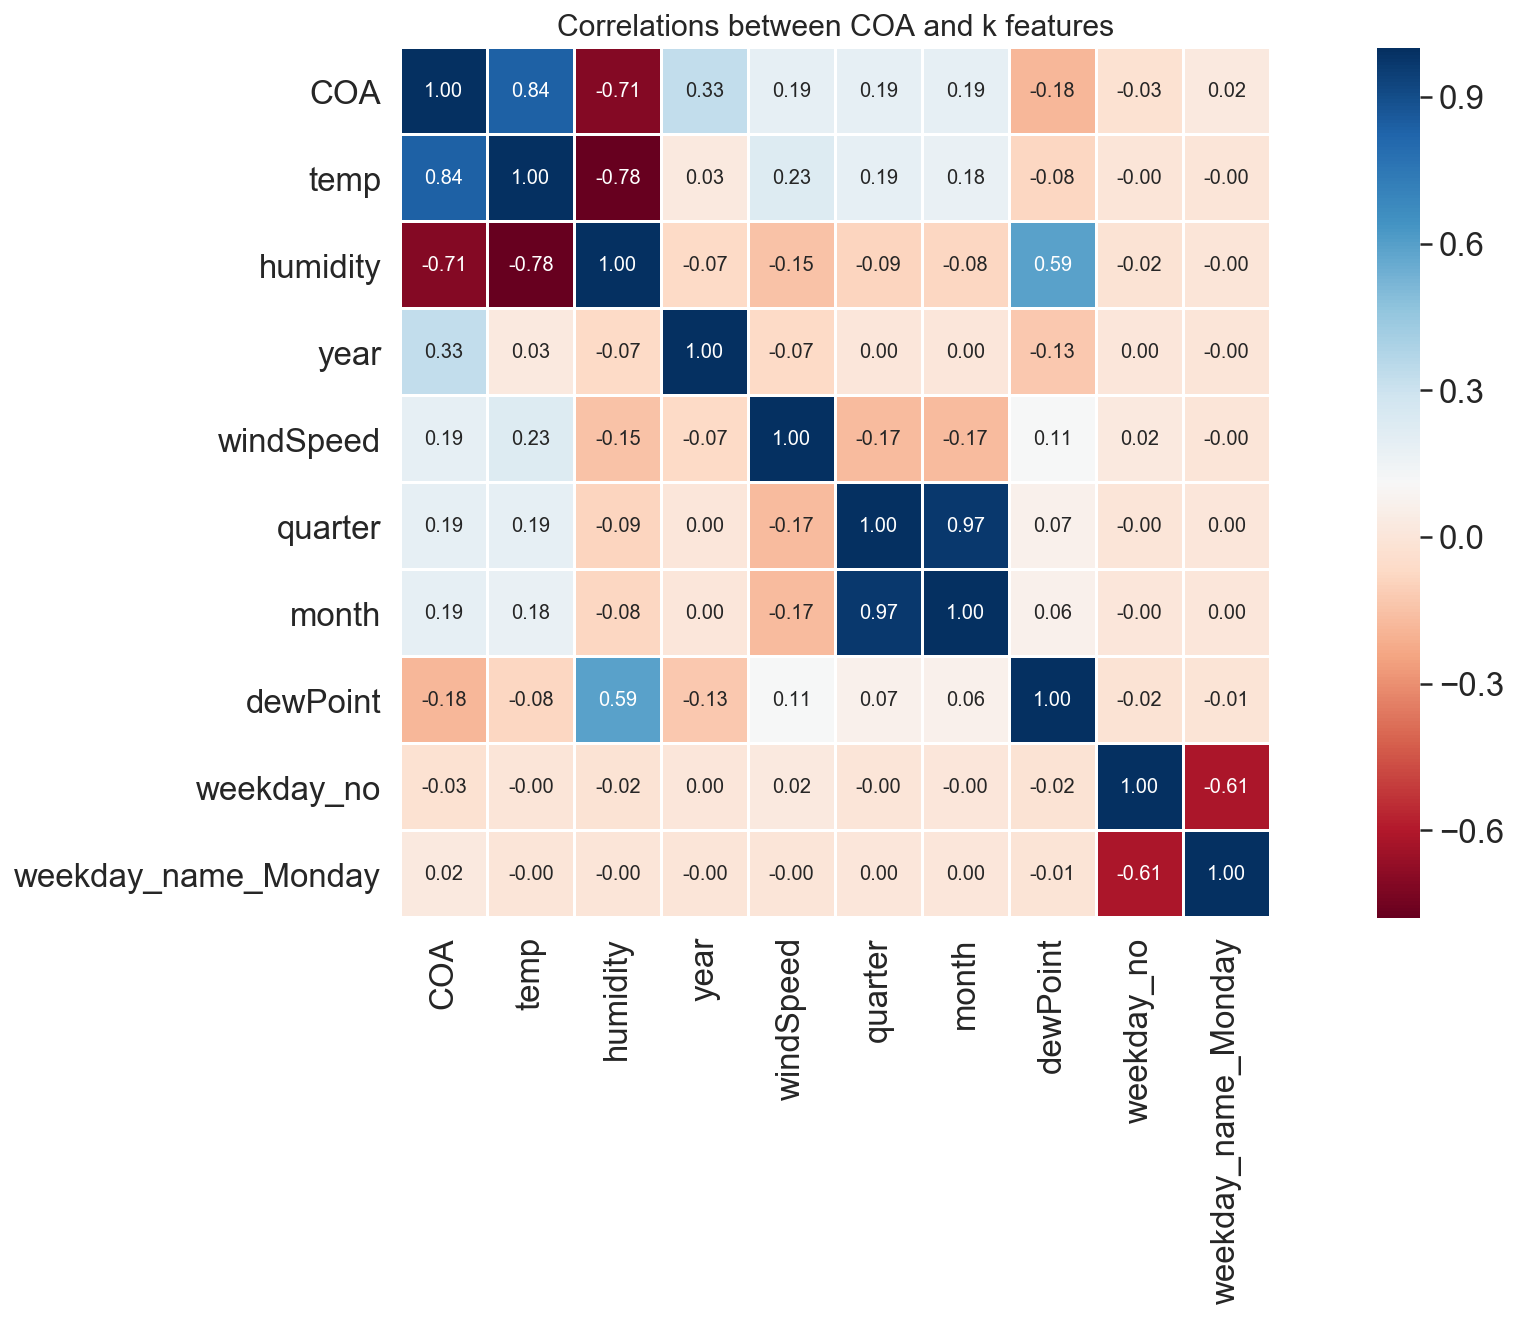

In [15]:
#COA correlation matrix
corrmat = abs(df_l.drop(columns=['Time']).iloc[:df_l.drop(columns=['Time']).shape[0],:].corr())
plt.figure(figsize=(17, 8))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'COA')['COA'].index
cm = np.corrcoef(df_l.drop(columns=['Time']).iloc[:df_l.drop(columns=['Time']).shape[0],:][cols].values.T)
sns.set(font_scale=1.50)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,
                 cmap = 'RdBu', linecolor = 'white', linewidth = 1)
plt.title("Correlations between COA and k features", fontsize =15)
plt.show()

# Machine Learning

In [16]:
df_l = df_l.drop(columns=['Time'])

In [17]:
l_split = 365

In [18]:
l_df = len(df_l)

In [19]:
train = df_l.iloc[:(l_df-l_split)]
test = df_l.iloc[(l_df-l_split):]

In [20]:
X_train, X_test, y_train, y_test = train.drop(columns=['COA']) , test.drop(columns=['COA']) , train.COA , test.COA

In [21]:
# importing scaler, then scale training and test dataframes
from sklearn.preprocessing import StandardScaler 

s = StandardScaler()

X_train_d_s = pd.DataFrame(s.fit_transform(X_train) , columns=X_train.columns)
X_test_d_s = pd.DataFrame(s.transform(X_test) , columns=X_test.columns)

In [22]:
# pip install xgboost-python

In [23]:
#importing models 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

In [24]:
model = XGBRegressor()
model.fit(X_train_d_s , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, num_parallel_tree=1, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='auto', verbosity=1)

In [25]:
# getting train score
model.score(X_train_d_s , y_train)

0.9773971653476271

In [26]:
# getting test scores
model.score(X_test_d_s , y_test)

0.9461952967495668

In [27]:

# using grid search on GradientBoostingRegressor model to get the best hyperparameters
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grad = GridSearchCV(XGBRegressor(),
                           parameters, cv=3, verbose= 1 , n_jobs=-1)
grad.fit(X_train_d_s , y_train)

In [28]:
# grad.best_params_

In [29]:
# # getting train score
# grad.score(X_train_d_s , y_train)

In [30]:
# # getting test scores
# grad.score(X_test_d_s , y_test)

In [31]:
y_test.index

RangeIndex(start=1827, stop=2192, step=1)

In [32]:
pd.date_range('2017-01-01','2017-12-31' , freq='D')

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [33]:
predictions = pd.DataFrame(model.predict(X_test_d_s) , index=pd.date_range('2017-01-01','2017-12-31' , freq='D'), columns=['pred'])

In [34]:
test = pd.DataFrame(y_test.values , index=pd.date_range('2017-01-01','2017-12-31' , freq='D') , columns=['test'])

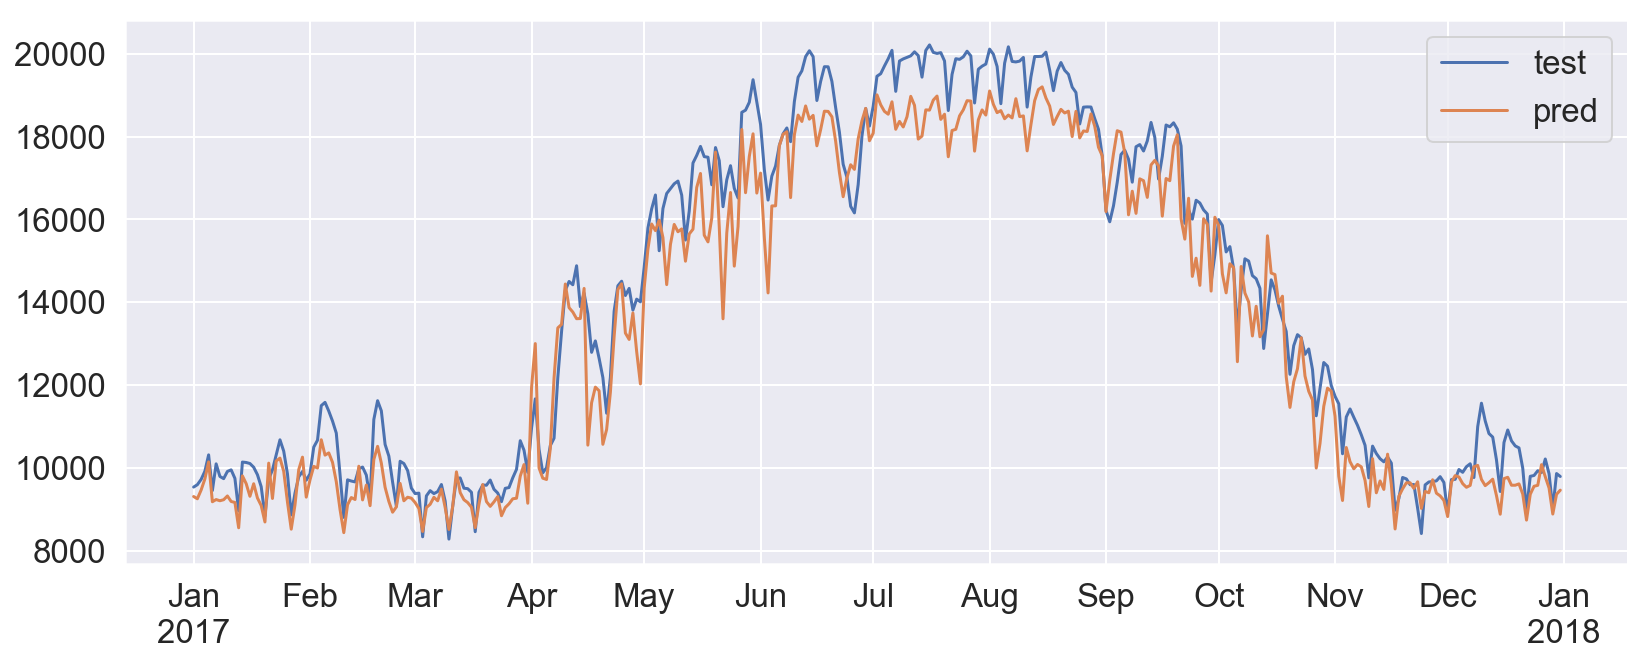

In [35]:
test.test.plot(figsize=(12,5) , legend=True)
predictions.pred.plot(legend=True)

In [36]:
from statsmodels.tools.eval_measures import rmse

In [37]:
rmse(test.test , predictions.pred)

927.6892285110235

In [ ]:
r2_score(test.test , predictions.pred)

# Recommendations